In [1]:
import os
import allel
import zarr
import pandas as pd
import petl as etl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
#import pyfasta
import dask
# quieten dask warnings about large chunks
dask.config.set(**{'array.slicing.split_large_chunks': True})
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

-----------------------------------------
## Admixture statistics

In [2]:
calldata_out= zarr.open('/media/storage/Ag1000G/Phase3/Data/Extras/outgroup_alleles_phase3.zarr')

In [3]:
calldata_biallel= zarr.open('/media/storage/Ag1000G/Phase3/Data/Extras/fw_biallelic_count_country.zarr/')

In [4]:
metadata = pd.read_csv('/media/storage/Ag1000G/Phase3/Data/Meta/west_africa_phase3_n2.csv')
metadata

,Unnamed: 0,sample_id,partner_sample_id,contributor,country,location,year,month,longitude,latitude,...,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species,locspe,population,2La_type,2Rd_type,pca_pops,pca_country
0,0,AB0085-Cx,BF2-4,Austin Burt,Burkina Faso,Pala,2012,7,-4.235,11.150,...,2.0,gamb_colu,gambiae,gambiae,2012_Burkina Faso_Pala_gambiae,SBF1_12,2La_alt,2Rd_hom,An.gam,BFgam
1,1,AB0086-Cx,BF2-6,Austin Burt,Burkina Faso,Pala,2012,7,-4.235,11.150,...,2.0,gamb_colu,gambiae,gambiae,2012_Burkina Faso_Pala_gambiae,SBF1_12,2La_alt,2Rd_hom,An.gam,BFgam
2,2,AB0087-C,BF3-3,Austin Burt,Burkina Faso,Bana,2012,7,-4.472,11.233,...,2.0,gamb_colu,coluzzii,coluzzii,2012_Burkina Faso_Bana_coluzzii,MBF2_12,2La_alt,2Rd_hom,An.col,BFcol
3,3,AB0088-C,BF3-5,Austin Burt,Burkina Faso,Bana,2012,7,-4.472,11.233,...,2.0,gamb_colu,coluzzii,coluzzii,2012_Burkina Faso_Bana_coluzzii,MBF2_12,2La_alt,2Rd_hom,An.col,BFcol
4,4,AB0089-Cx,BF3-8,Austin Burt,Burkina Faso,Bana,2012,7,-4.472,11.233,...,2.0,gamb_colu,coluzzii,coluzzii,2012_Burkina Faso_Bana_coluzzii,MBF2_12,2La_alt,2Rd_hom,An.col,BFcol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,1185,AJ0060-C,BIS038,Joao Pinto,Guinea-Bissau,Antula,2010,-1,-15.582,11.891,...,6.0,gamb_colu,intermediate,intermediate_gambiae_coluzzii,2010_Guinea-Bissau_Antula_intermediate_gambiae...,FW2,2La_hom,2Rd_hom,GW,GW
1186,1186,AJ0068-C,BIS046,Joao Pinto,Guinea-Bissau,Antula,2010,-1,-15.582,11.891,...,6.0,gamb_colu,intermediate,intermediate_gambiae_coluzzii,2010_Guinea-Bissau_Antula_intermediate_gambiae...,FW2,2La_het,2Rd_hom,GW,GW
1187,1187,AJ0080-C,BIS058,Joao Pinto,Guinea-Bissau,Antula,2010,-1,-15.582,11.891,...,5.0,gamb_colu,intermediate,intermediate_gambiae_coluzzii,2010_Guinea-Bissau_Antula_intermediate_gambiae...,FW2,2La_het,2Rd_hom,GW,GW
1188,1188,AJ0087-C,BIS065,Joao Pinto,Guinea-Bissau,Antula,2010,-1,-15.582,11.891,...,6.0,gamb_colu,intermediate,intermediate_gambiae_coluzzii,2010_Guinea-Bissau_Antula_intermediate_gambiae...,FW2,2La_het,2Rd_hom,GW,GW


In [5]:
ac_cache = dict()

def load_ac(chrom, pop):
    if (chrom, pop) in ac_cache:
        return ac_cache[chrom, pop]
    else:
        if pop in out_species:
            ac = calldata_out[chrom][pop][:,:2]
        else:
            ac = calldata_biallel[chrom][pop]
            ac_cache[chrom, pop] = ac
        return ac

In [6]:
fourpop_cache = dict()

In [7]:
chromosomes = ['3L', '3R']
out_species = ['chri', 'epir']

In [8]:
metadata.pca_country.unique()

array(['BFgam', 'BFcol', 'CIcol', 'GHcol', 'GHgam', 'GM-2', 'GM-1',
       'GNgam', 'GNcol', 'MAgam', 'MAcol', 'GW', 'GWgam'], dtype=object)

In [9]:
an_col = 'BFcol', 'CIcol', 'GHcol','GNcol', 'MAcol'
an_gam = 'BFgam','GHgam', 'GNgam', 'MAgam', 'GWgam'
an_na = 'GM-1', 'GM-2', 'GW'

----------------------------------------------
## ABBA BABA TEST WITH <i> An. christyi </i>

In [14]:
def f4_analysis(chroms, A, B, C, D, regions=None, blen=100000, plot=False, ax=None):
    
    
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    
    key = (",".join(chroms), region_str, A, B, C, D, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = dask.array.vstack([load_ac(chrom, A)[region] for chrom, region in zip(chroms, regions)])
        acb = dask.array.vstack([load_ac(chrom, B)[region] for chrom, region in zip(chroms, regions)])
        acc = dask.array.vstack([load_ac(chrom, C)[region] for chrom, region in zip(chroms, regions)])
        acd = dask.array.vstack([load_ac(chrom, D)[region] for chrom, region in zip(chroms, regions)])
            
        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.blockwise_patterson_d(aca, acb, acc, acd, 
                                                                     blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

def f4_analys(As, Bs, Cs, Ds, chroms=chromosomes, regions=None, blen=100000):
    
    if regions is None:
        regions = [slice(None)] * 4
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]
    if not isinstance(Ds, (list, tuple)):
        Ds = [Ds]
        
    # setup output table
    tbl = [['chromosome', 'test', 'D', 'SE', 'Z']]

    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                    for D in Ds:
                        if C != D:
                            d, d_se, d_z, _, _ = f4_analysis(chroms, A, B, C, D, 
                                                             regions=regions, blen=blen)
                            test = 'D(%s, %s; %s, %s)' % (A, B, C, D)
                            row = [",".join(chroms), test, d, d_se, d_z]
                            tbl += [row]
                        

    # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    
def tbl_display(tbl):
        # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    
def tbl_d_plot(table, title):
    # plot
    tbl = etl.wrap(table).sort('test')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
    
    ## First Plot - Bar Plot
    x = tbl.values('D').array()
    y = np.arange(tbl.nrows())
    ax1.axvline(0, color='r', lw=1)
    xerr = tbl.values('SE').array()
    ax1.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
    ax1.set_yticks(y)
    ylbls = ['%s; Z = %.1f' % (v.test, v.Z) for v in tbl.records()]
    ax1.set_yticklabels(ylbls)
    ax1.yaxis.tick_right()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(-.2,.2)
    ax1.set_ylim(-1, y.size)
    ax1.grid(axis='both', color='#dddddd')
    ax1.set_xlabel("Patterson's $D$ Barplot")
    fig.suptitle('%s' % (title), y=1.02, fontsize=16)

    ## Second plot - Heatmap
    results = etl.todataframe(tbl)
    df1 = results[['test', 'D','Z']].round(2)
    heatmap1_data = pd.pivot_table(df1, values='Z', 
                     index=['test'], 
                     columns='D')
    lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=15, vmax=-15, annot=True)
    ax2 = lm.axes
    ax2.set_xlim(-.7)
    #ax2.set_ylim(40.4)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xticks(rotation=70)
    ax2.set_xlabel("Patterson's $D$ Heatmap")
    ax2.invert_yaxis()
    plt.text(1.02, 0.5, 'Z-score', {'fontsize': 15},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

    ax2.grid(False, 'major')
    ax2.grid(True, 'minor')
    ax2.set_yticks([t - 0.5 for t in ax2.get_yticks()], minor=True)
    sns.despine()
    fig.tight_layout()
    plt.show()  

----------------


In [15]:
A = an_gam
B = an_na
C = an_col
D = 'chri'

In [16]:
d_col = f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,D,SE,Z
"3L,3R","D(BFgam, GM-1; BFcol, chri)",-0.047,0.0030,-15.8
"3L,3R","D(BFgam, GM-1; CIcol, chri)",-0.055,0.0029,-19.1
"3L,3R","D(BFgam, GM-1; GHcol, chri)",-0.056,0.0030,-19.0
"3L,3R","D(BFgam, GM-1; GNcol, chri)",-0.058,0.0031,-18.6
"3L,3R","D(BFgam, GM-1; MAcol, chri)",-0.047,0.0030,-15.8
"3L,3R","D(BFgam, GM-2; BFcol, chri)",-0.024,0.0015,-15.7
"3L,3R","D(BFgam, GM-2; CIcol, chri)",-0.030,0.0015,-19.9
"3L,3R","D(BFgam, GM-2; GHcol, chri)",-0.031,0.0015,-20.3
"3L,3R","D(BFgam, GM-2; GNcol, chri)",-0.034,0.0016,-20.3
"3L,3R","D(BFgam, GM-2; MAcol, chri)",-0.024,0.0015,-15.5


In [17]:
A = an_col
B = an_na
C = an_gam
D = 'chri'

In [18]:
d_gam =f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,D,SE,Z
"3L,3R","D(BFcol, GM-1; BFgam, chri)",0.014,0.0011,12.4
"3L,3R","D(BFcol, GM-1; GHgam, chri)",0.014,0.0011,12.5
"3L,3R","D(BFcol, GM-1; GNgam, chri)",0.014,0.0012,12.4
"3L,3R","D(BFcol, GM-1; MAgam, chri)",0.014,0.0011,12.2
"3L,3R","D(BFcol, GM-1; GWgam, chri)",0.012,0.0010,11.5
"3L,3R","D(BFcol, GM-2; BFgam, chri)",0.005,0.0018,2.6
"3L,3R","D(BFcol, GM-2; GHgam, chri)",0.004,0.0019,2.1
"3L,3R","D(BFcol, GM-2; GNgam, chri)",0.005,0.0018,2.7
"3L,3R","D(BFcol, GM-2; MAgam, chri)",0.005,0.0017,3.0
"3L,3R","D(BFcol, GM-2; GWgam, chri)",0.003,0.0018,1.5


-----------------------------------------
## f3 Statistics

In [10]:
def f4_analysis(chroms, A, B, C, regions=None, blen=100000, plot=False, ax=None):
    
    
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    
    key = (",".join(chroms), region_str, A, B, C, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = dask.array.vstack([load_ac(chrom, A)[region] for chrom, region in zip(chroms, regions)])
        acb = dask.array.vstack([load_ac(chrom, B)[region] for chrom, region in zip(chroms, regions)])
        acc = dask.array.vstack([load_ac(chrom, C)[region] for chrom, region in zip(chroms, regions)])
            
        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.average_patterson_f3(aca, acb, acc, 
                                                                     blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

def f4_analys(As, Bs, Cs, chroms=chromosomes, regions=None, blen=100000):
    
    if regions is None:
        regions = [slice(None)] * 4
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]

    # setup output table
    tbl = [['chromosome', 'test', 'f3', 'SE', 'Z']]

    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                        if B != C:
                            d, d_se, d_z, _, _ = f4_analysis(chroms, A, B, C,  
                                                             regions=regions, blen=blen)
                            test = 'f3(%s, %s; %s)' % (A, B, C)
                            row = [",".join(chroms), test, d, d_se, d_z]
                            tbl += [row]

    # display results
    (etl
     .wrap(tbl)
     .interpolate('f3', '%.5f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 3 else '#aaf' if float(row.Z) < -3 else 'white')))


def tbl_d_plot(table, title):
    # plot
    tbl = etl.wrap(table).sort('test')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
    
    ## First Plot - Bar Plot
    x = tbl.values('f3').array()
    y = np.arange(tbl.nrows())
    ax1.axvline(0, color='r', lw=1)
    xerr = tbl.values('SE').array()
    ax1.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
    ax1.set_yticks(y)
    ylbls = ['%s; Z = %.1f' % (v.test, v.Z) for v in tbl.records()]
    ax1.set_yticklabels(ylbls)
    ax1.yaxis.tick_right()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(-.2,.2)
    ax1.set_ylim(-1, y.size)
    ax1.grid(axis='both', color='#dddddd')
    ax1.set_xlabel("F3 Statistics Barplot")
    fig.suptitle('%s' % (title), y=1.02, fontsize=16)

    ## Second plot - Heatmap
    results = etl.todataframe(tbl)
    df1 = results[['test', 'f3','Z']].round(2)
    heatmap1_data = pd.pivot_table(df1, values='Z', 
                     index=['test'], 
                     columns='f3')
    lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=15, vmax=-15, annot=True)
    ax2 = lm.axes
    ax2.set_xlim(-.7)
    #ax2.set_ylim(40.4)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xticks(rotation=70)
    ax2.set_xlabel("F3 Statistics Heatmap")
    ax2.invert_yaxis()
    plt.text(1.02, 0.5, 'Z-score', {'fontsize': 15},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

    ax2.grid(False, 'major')
    ax2.grid(True, 'minor')
    ax2.set_yticks([t - 0.5 for t in ax2.get_yticks()], minor=True)
    sns.despine()
    fig.tight_layout()
    plt.show()  

In [17]:
A = an_na
B = an_gam
C = an_col

In [18]:
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))
f3_an

chromosome,test,f3,SE,Z
"3L,3R","f3(GM-1, BFgam; BFcol)",0.00771,0.0005,15.6
"3L,3R","f3(GM-1, BFgam; CIcol)",0.00481,0.0004,11.5
"3L,3R","f3(GM-1, BFgam; GHcol)",0.00439,0.0004,11.1
"3L,3R","f3(GM-1, BFgam; GNcol)",0.00304,0.0003,10.8
"3L,3R","f3(GM-1, BFgam; MAcol)",0.00773,0.0005,15.5
"3L,3R","f3(GM-1, GHgam; BFcol)",0.00738,0.0005,15.1
"3L,3R","f3(GM-1, GHgam; CIcol)",0.00466,0.0004,11.3
"3L,3R","f3(GM-1, GHgam; GHcol)",0.00422,0.0004,11.0
"3L,3R","f3(GM-1, GHgam; GNcol)",0.00289,0.0003,10.3
"3L,3R","f3(GM-1, GHgam; MAcol)",0.00739,0.0005,15.0


In [56]:
### test admixture GM-2 GM-1 An.col
A = an_col
B = 'GM-1'
C = 'GM-2'

In [57]:
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))
f3_an

chromosome,test,f3,SE,Z
"3L,3R","f3(BFcol, GM-1; GM-2)",0.009,0.0007,13.0
"3L,3R","f3(CIcol, GM-1; GM-2)",0.016,0.0006,26.4
"3L,3R","f3(GHcol, GM-1; GM-2)",0.014,0.0008,18.1
"3L,3R","f3(GNcol, GM-1; GM-2)",0.049,0.0006,88.0
"3L,3R","f3(MAcol, GM-1; GM-2)",0.009,0.0007,13.4


In [60]:
### test admixture GM-2 GM-1 An.col
A = an_gam
B = 'GM-1'
C = 'GM-2'

In [61]:
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))
f3_an

chromosome,test,f3,SE,Z
"3L,3R","f3(BFgam, GM-1; GM-2)",0.023,0.0012,19.8
"3L,3R","f3(GHgam, GM-1; GM-2)",0.026,0.0012,21.5
"3L,3R","f3(GNgam, GM-1; GM-2)",0.024,0.0011,21.1
"3L,3R","f3(MAgam, GM-1; GM-2)",0.024,0.0010,23.0
"3L,3R","f3(GWgam, GM-1; GM-2)",0.018,0.0009,21.2


In [13]:
A = an_col
B = 'GM-1'
C = 'GW'

In [14]:
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))
f3_an

chromosome,test,f3,SE,Z
"3L,3R","f3(BFcol, GM-1; GW)",0.010,0.0008,13.0
"3L,3R","f3(CIcol, GM-1; GW)",0.016,0.0006,25.1
"3L,3R","f3(GHcol, GM-1; GW)",0.014,0.0008,17.7
"3L,3R","f3(GNcol, GM-1; GW)",0.049,0.0006,87.1
"3L,3R","f3(MAcol, GM-1; GW)",0.010,0.0008,13.4


In [15]:
A = an_col
B = 'GM-2'
C = 'GW'

In [16]:
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))
f3_an

chromosome,test,f3,SE,Z
"3L,3R","f3(BFcol, GM-2; GW)",0.019,0.0015,13.2
"3L,3R","f3(CIcol, GM-2; GW)",0.026,0.0013,20.0
"3L,3R","f3(GHcol, GM-2; GW)",0.025,0.0015,16.2
"3L,3R","f3(GNcol, GM-2; GW)",0.059,0.0012,47.7
"3L,3R","f3(MAcol, GM-2; GW)",0.019,0.0014,13.4


In [17]:
### test admixture in GW
A = an_col
B = 'GW'
C = 'GM-2'
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))
f3_an

chromosome,test,f3,SE,Z
"3L,3R","f3(BFcol, GW; GM-2)",0.019,0.0015,13.2
"3L,3R","f3(CIcol, GW; GM-2)",0.026,0.0013,20.0
"3L,3R","f3(GHcol, GW; GM-2)",0.025,0.0015,16.2
"3L,3R","f3(GNcol, GW; GM-2)",0.059,0.0012,47.7
"3L,3R","f3(MAcol, GW; GM-2)",0.019,0.0014,13.4


In [34]:
A = 'GW'
B = an_col
C = 'GM-2'
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))
f3_an

chromosome,test,f3,SE,Z
"3L,3R","f3(GW, BFcol; GM-2)",-0.00063,0.0002,-3.5
"3L,3R","f3(GW, CIcol; GM-2)",-0.00088,0.0002,-4.9
"3L,3R","f3(GW, GHcol; GM-2)",-0.00103,0.0002,-5.5
"3L,3R","f3(GW, GNcol; GM-2)",-0.00103,0.0002,-5.7
"3L,3R","f3(GW, MAcol; GM-2)",-0.00062,0.0002,-3.4


In [17]:
A = 'GW'
B = 'GM-2'
C = 'GM-1'
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))
f3_an

chromosome,test,f3,SE,Z
"3L,3R","f3(GW, GM-2; GM-1)",-0.00141,0.0002,-7.5


In [31]:
A = 'GW'
B = an_col
C = 'GM-1'
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))
f3_an

chromosome,test,f3,SE,Z
"3L,3R","f3(GW, BFcol; GM-1)",0.00858,0.0007,12.2
"3L,3R","f3(GW, CIcol; GM-1)",0.00888,0.0007,13.1
"3L,3R","f3(GW, GHcol; GM-1)",0.00898,0.0007,12.8
"3L,3R","f3(GW, GNcol; GM-1)",0.00825,0.0007,12.2
"3L,3R","f3(GW, MAcol; GM-1)",0.00851,0.0007,12.1


In [3]:
d = pd.read_csv('../Data/Extras/f3_results.csv', sep='\t')
d

,test,f3,SE,Z
0,"(GW, (BFcol; GM-2))",-0.00063,0.0002,-3.5
1,"(GW, (CIcol; GM-2))",-0.00088,0.0002,-4.9
2,"(GW, (GHcol; GM-2))",-0.00103,0.0002,-5.5
3,"(GW, (GNcol; GM-2))",-0.00103,0.0002,-5.7
4,"(GW, (MAcol; GM-2))",-0.00062,0.0002,-3.4
5,"(GW, (GM-1; GM-2))",-0.00141,0.0002,-7.5
6,"(GW, (BFcol; GM-1)",0.00858,0.0007,12.2
7,"(GW, (CIcol; GM-1))",0.00888,0.0007,13.1
8,"(GW, (GHcol; GM-1))",0.00898,0.0007,12.8
9,"(GW, (GNcol; GM-1))",0.00825,0.0007,12.2


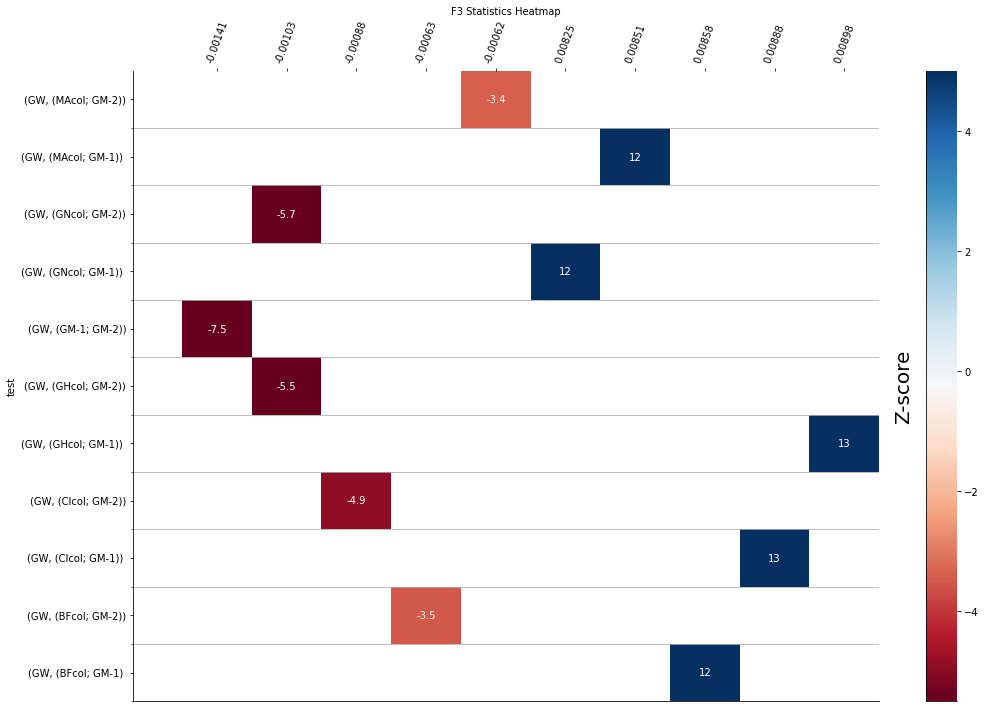

In [4]:
fig, ax = plt.subplots(1,figsize=(15,10))
heatmap1_data = pd.pivot_table(d, values='Z', 
                     index=['test'], 
                     columns='f3')
lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=5, vmax=-5, annot=True)
ax = lm.axes
ax.set_xlim(-.7)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(rotation=70)
ax.set_xlabel("F3 Statistics Heatmap")
ax.invert_yaxis()
plt.text(1.02, 0.5, 'Z-score', {'fontsize': 20},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

ax.grid(False, 'major')
ax.grid(True, 'minor')
ax.set_yticks([t - 0.5 for t in ax.get_yticks()], minor=True)
sns.despine()
fig.tight_layout()
plt.show()  

In [5]:
ylbls = d.test
x = np.array(d.f3)
y = np.arange(len(d))
ax.axvline(0, color='r', lw=1)
xerr = np.array(d.SE)

Text(0.5, 0, 'F3 Statistics Barplot')

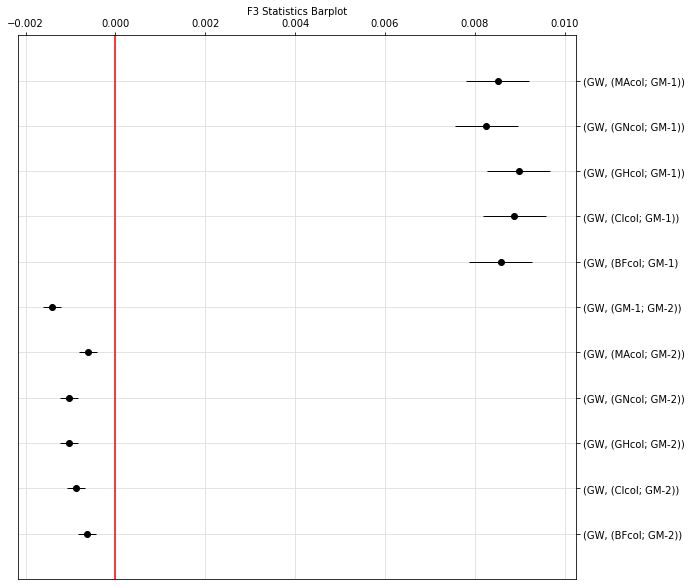

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
ax.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
ax.set_yticks(y)
ylbls = d.test
ax.set_yticklabels(ylbls)
ax.yaxis.tick_right()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
#ax.set_xlim(-.0015,.01)
plt.axvline(x=0, color='r', linestyle='-')
ax.set_ylim(-1, y.size)
ax.grid(axis='both', color='#dddddd')
ax.set_xlabel("F3 Statistics Barplot")
#fig.suptitle('%s' % (title), y=1.02, fontsize=16)

--------------------------------------